## Big Data Analytics - Lab Quest 3
### Instructure: Michał Rudko
### Student: Nhat Tung Le, Id 426246, Group 1

# Abstract

Recommender System uses AI technology to analyze and understand personal data blocks, thereby, making predictions, suggesting recommendations that match the user's preferences at the time. any on online applications and platforms to save time searching, easy access to content, and at the same time, help businesses improve customer experience.

In this project, I use Apache Spark, SQL, and MLib for data analysis, and build a recommendation system based on the MovieLens dataset.

# 1. Introduction

## 1.1. Apache Spark 

Apache Spark is an open source cluster computing framework, originally developed in 2009 by AMPLab. Later on, Spark was given to Apache Software Foundation in 2013 and developed to date.

Spark's processing speed is achieved because the computation is done at the same time on many different machines. At the same time, the calculation is done in internal memory (in-memories) or done entirely in RAM.

Spark allows real-time data processing, both receiving data from different sources and immediately performing processing on the received data (Spark Streaming).

Spark does not have its own file system, it uses other file systems such as: HDFS, Cassandra, S3,.... Spark supports many different file formats (text, csv, json…) and it is completely independent of any file system.

Apache Spark consists of 5 main components: Spark Core, Spark Streaming, Spark SQL, MLlib and GraphX.

## 1.2. PyPark

PySpark is the Python API for Apache Spark, an open source, distributed computing framework and set of libraries for real-time, large-scale data processing. If you’re already familiar with Python and libraries such as Pandas, then PySpark is a good language to learn to create more scalable analyses and pipelines.

To install PysPark, we can use the following command:

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.3. MLlib

MLlib is Spark’s machine learning (ML) library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:
* ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
* Featurization: feature extraction, transformation, dimensionality reduction, and selection
* Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
* Persistence: saving and load algorithms, models, and Pipelines
* Utilities: linear algebra, statistics, data handling, etc.

## 1.4. Alternating Least Square (ALS)

Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.


## 1.5. MovieLens 20M Dataset

MovieLens 20M movie ratings. Stable benchmark dataset. 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags. Released 4/2015; updated 10/2016 to update links.csv and add tag genome data.

Link: <a href="https://grouplens.org/datasets/movielens/20m/">https://grouplens.org/datasets/movielens/20m/</a>

# 2. Exploratory data analysis

## 2.1. Libs and create spark app

In [2]:
# Required libraries:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession 
from pyspark.sql import functions as F 
from pyspark.sql.functions import col, split, explode
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import countDistinct as _countDistinct
from pyspark.sql.functions import avg as _avg
from pyspark.sql.functions import rank
from pyspark.sql.functions import substring,length
from pyspark.sql.types import DateType, StringType, FloatType, IntegerType 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder


In [3]:
# Step 1:  Connect to Our drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/DataSet/MovieLens"
os.chdir(path)
os.listdir()

['genome-scores.csv',
 'links.csv',
 'genome-tags.csv',
 'movies.csv',
 'tags.csv',
 'ratings.csv',
 'README.txt',
 'model.pkl',
 'model.joblib',
 'model.h5']

In [5]:
# Create spark
spark = SparkSession.builder.master('local[*]').appName("MovieLens").getOrCreate()

## 2.2. Check schema and create DataFrame

In [6]:
## movies
movies_df = spark.read.csv("movies.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
movies_df.show() 
movies_df.printSchema()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [7]:
## tags
tags_df = spark.read.csv("tags.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
tags_df.show() 
tags_df.printSchema()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|    18|   4141|      Mark Waters|1240597180|
|    65|    208|        dark hero|1368150078|
|    65|    353|        dark hero|1368150079|
|    65|    521|    noir thriller|1368149983|
|    65|    592|        dark hero|1368150078|
|    65|    668|        bollywood|1368149876|
|    65|    898| screwball comedy|1368150160|
|    65|   1248|    noir thriller|1368149983|
|    65|   1391|             mars|1368150055|
|    65|   1617|         neo-noir|1368150217|
|    65|   1694|            jesus|1368149925|
|    65|   1783|    noir thriller|1368149983|
|    65|   2022|            jesus|1368149925|
|    65|   2193|           dragon|1368151314|
|    65|   2353|conspiracy theory|1368151266|
|    65|   2662|             mars|1368150055|
|    65|   2726|    noir thriller|1368149983|
|    65|   2840|            jesus|1368149925|
|    65|   3052|            jesus|

In [8]:
## ratings
ratings_df = spark.read.csv("ratings.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
ratings_df.show() 
ratings_df.printSchema()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timesta

In [9]:
## links
links_df = spark.read.csv("links.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
links_df.show() 
links_df.printSchema()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [10]:
## genome-tags
genome_tags_df = spark.read.csv("genome-tags.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
genome_tags_df.show() 
genome_tags_df.printSchema()

+-----+---------------+
|tagId|            tag|
+-----+---------------+
|    1|            007|
|    2|   007 (series)|
|    3|   18th century|
|    4|          1920s|
|    5|          1930s|
|    6|          1950s|
|    7|          1960s|
|    8|          1970s|
|    9|          1980s|
|   10|   19th century|
|   11|             3d|
|   12|           70mm|
|   13|            80s|
|   14|           9/11|
|   15|        aardman|
|   16|aardman studios|
|   17|       abortion|
|   18|         absurd|
|   19|         action|
|   20|  action packed|
+-----+---------------+
only showing top 20 rows

root
 |-- tagId: integer (nullable = true)
 |-- tag: string (nullable = true)



In [11]:
## genome-scores
genome_scores_df = spark.read.csv("genome-scores.csv", sep=",", header = True, inferSchema=True, nullValue="NA")
genome_scores_df.show() 
genome_scores_df.printSchema()

+-------+-----+--------------------+
|movieId|tagId|           relevance|
+-------+-----+--------------------+
|      1|    1|0.025000000000000022|
|      1|    2|0.025000000000000022|
|      1|    3|0.057750000000000024|
|      1|    4|             0.09675|
|      1|    5|             0.14675|
|      1|    6| 0.21700000000000003|
|      1|    7|               0.067|
|      1|    8| 0.26275000000000004|
|      1|    9|               0.262|
|      1|   10| 0.03199999999999997|
|      1|   11|               0.577|
|      1|   12| 0.11625000000000002|
|      1|   13|               0.188|
|      1|   14|0.008000000000000007|
|      1|   15|0.036750000000000005|
|      1|   16| 0.28174999999999994|
|      1|   17|0.007000000000000006|
|      1|   18| 0.11049999999999999|
|      1|   19|              0.6705|
|      1|   20|              0.1845|
+-------+-----+--------------------+
only showing top 20 rows

root
 |-- movieId: integer (nullable = true)
 |-- tagId: integer (nullable = true)
 |-

In [12]:
# Summary all DataFrame
display(movies_df)
display(tags_df)
display(genome_tags_df)
display(genome_scores_df)
display(links_df)
display(ratings_df)

DataFrame[movieId: int, title: string, genres: string]

DataFrame[userId: int, movieId: int, tag: string, timestamp: int]

DataFrame[tagId: int, tag: string]

DataFrame[movieId: int, tagId: int, relevance: double]

DataFrame[movieId: int, imdbId: int, tmdbId: int]

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

## 2.3. Informations

In [13]:
# Number of unique movies
movies_df.createOrReplaceTempView("movies")
unique_movies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM movies").collect()[0][0]
print("Number of unique movies:", unique_movies)

Number of unique movies: 27278


In [14]:
# Number of users participating in rating points for movies
ratings_df.createOrReplaceTempView("ratings")
unique_users = spark.sql("SELECT COUNT(DISTINCT userId) FROM ratings").collect()[0][0]
print("Number of users participating in rating points for movies:", unique_users)

Number of users participating in rating points for movies: 138493


In [15]:
# Split genres
movies_df_2 = movies_df.withColumn("genres", explode(split("genres", "[|]")))
movies_df_2.show()
movies_df_2.printSchema()

+-------+--------------------+---------+
|movieId|               title|   genres|
+-------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|
|      1|    Toy Story (1995)|Animation|
|      1|    Toy Story (1995)| Children|
|      1|    Toy Story (1995)|   Comedy|
|      1|    Toy Story (1995)|  Fantasy|
|      2|      Jumanji (1995)|Adventure|
|      2|      Jumanji (1995)| Children|
|      2|      Jumanji (1995)|  Fantasy|
|      3|Grumpier Old Men ...|   Comedy|
|      3|Grumpier Old Men ...|  Romance|
|      4|Waiting to Exhale...|   Comedy|
|      4|Waiting to Exhale...|    Drama|
|      4|Waiting to Exhale...|  Romance|
|      5|Father of the Bri...|   Comedy|
|      6|         Heat (1995)|   Action|
|      6|         Heat (1995)|    Crime|
|      6|         Heat (1995)| Thriller|
|      7|      Sabrina (1995)|   Comedy|
|      7|      Sabrina (1995)|  Romance|
|      8| Tom and Huck (1995)|Adventure|
+-------+--------------------+---------+
only showing top

In [16]:
# Statistics of movies by genre:
genres_count_df = movies_df_2.groupBy("genres").count()
genres_count_df.show()

+------------------+-----+
|            genres|count|
+------------------+-----+
|             Crime| 2939|
|           Romance| 4127|
|          Thriller| 4178|
|         Adventure| 2329|
|             Drama|13344|
|               War| 1194|
|       Documentary| 2471|
|           Fantasy| 1412|
|           Mystery| 1514|
|           Musical| 1036|
|         Animation| 1027|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
|            Horror| 2611|
|           Western|  676|
|            Comedy| 8374|
|          Children| 1139|
|            Action| 3520|
|            Sci-Fi| 1743|
+------------------+-----+



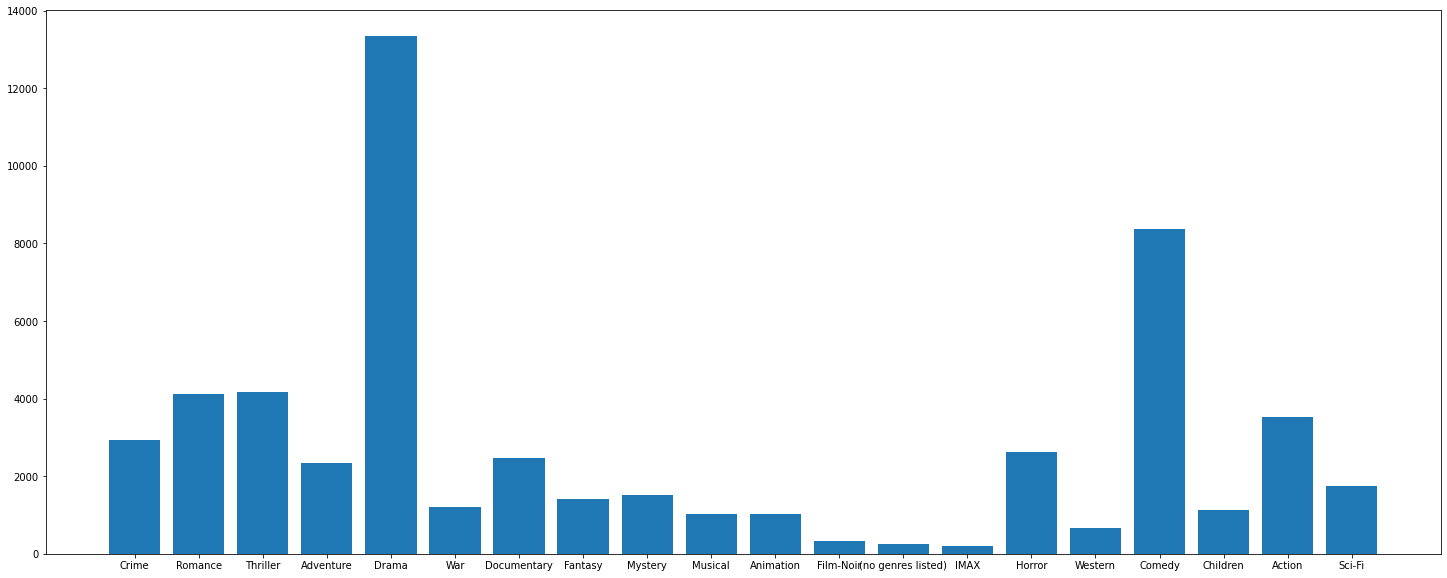

In [17]:
genres_count_df_2 = genres_count_df.select("genres", "count").toPandas()
plt.figure(figsize=(25, 10))
plt.bar(genres_count_df_2['genres'], genres_count_df_2['count'])
plt.show()

In [18]:
# Join movies_df & ratings_df
joined_ratings_df = movies_df.join(ratings_df, movies_df.movieId == ratings_df.movieId, "inner").drop(ratings_df.movieId)
joined_ratings_df.show()

+-------+--------------------+--------------------+------+------+----------+
|movieId|               title|              genres|userId|rating| timestamp|
+-------+--------------------+--------------------+------+------+----------+
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|1112486027|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|1112484676|
|     32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|1112484819|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|1112484727|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|1112484580|
|    112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|1094785740|
|    151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|1094785734|
|    223|       Clerks (1994)|              Comedy|     1|   4.0|1112485573|
|    253|Interview with th...|        Drama|Horror|     1|   4.0|1112484940|
|    260|Star Wars: Episod...|Action|Adventure|...|     1|   4.0|1112484826|

In [19]:
# Top 150 highest rated films 
# groupBy by and orderBy desc
joined_ratings_df.drop("timestamp")
joined_avg_ratings_df = joined_ratings_df.groupBy("userId", "title").agg(_avg("rating").alias("avg_rating"))
desc_df = joined_avg_ratings_df.orderBy(joined_avg_ratings_df.avg_rating.desc())
# desc_df.show()

In [20]:
# Print top 150
top_150 = desc_df.limit(150)
top_150.show(150)

+------+--------------------+----------+
|userId|               title|avg_rating|
+------+--------------------+----------+
|    24| Little Nicky (2000)|       5.0|
|    73|Searching for Bob...|       5.0|
|    24|  Point Break (1991)|       5.0|
|     2|Star Trek: First ...|       5.0|
|    24|Prophecy, The (1995)|       5.0|
|     3|Dead Zone, The (1...|       5.0|
|    24|    Ring, The (2002)|       5.0|
|     3|       Malice (1993)|       5.0|
|    24|  Scary Movie (2000)|       5.0|
|     3|Young Frankenstei...|       5.0|
|    24|     Swingers (1996)|       5.0|
|     5|        Speed (1994)|       5.0|
|    24|Terminator, The (...|       5.0|
|     6|Birdcage, The (1996)|       5.0|
|    53|      Amateur (1994)|       5.0|
|    73|Schindler's List ...|       5.0|
|    53|  Brassed Off (1996)|       5.0|
|    11|AVPR: Aliens vs. ...|       5.0|
|    53|        Limbo (1999)|       5.0|
|    11|    Annapolis (2006)|       5.0|
|    53|Night on Earth (1...|       5.0|
|    11|Bachelor

In [21]:
# Convert timestamp to "yyyy-mm-dd"
try:
    joined_ratings_df = joined_ratings_df.withColumn("timestamp2", F.to_date(F.from_unixtime(joined_ratings_df["timestamp"])))
    joined_ratings_df = joined_ratings_df.drop("timestamp")
    joined_ratings_df = joined_ratings_df.withColumnRenamed("timestamp2", "timestamp")
except:
    print("ERR")

joined_ratings_df = joined_ratings_df.dropna()    
joined_ratings_df.show()

+-------+--------------------+--------------------+------+------+----------+
|movieId|               title|              genres|userId|rating| timestamp|
+-------+--------------------+--------------------+------+------+----------+
|      2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02|
|     29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02|
|     32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|2005-04-02|
|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|2005-04-02|
|     50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|2005-04-02|
|    112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|2004-09-10|
|    151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|2004-09-10|
|    223|       Clerks (1994)|              Comedy|     1|   4.0|2005-04-02|
|    253|Interview with th...|        Drama|Horror|     1|   4.0|2005-04-02|
|    260|Star Wars: Episod...|Action|Adventure|...|     1|   4.0|2005-04-02|

In [22]:
df = joined_avg_ratings_df
df = df.dropna()
df.show()

+------+--------------------+----------+
|userId|               title|avg_rating|
+------+--------------------+----------+
|    11|         Jaws (1975)|       4.0|
|    11|      Gattaca (1997)|       5.0|
|    11|Appleseed (Appuru...|       5.0|
|    13|  Judge Dredd (1995)|       3.0|
|    14|Singin' in the Ra...|       3.5|
|    14|   Cinderella (1950)|       4.0|
|    18|Being John Malkov...|       4.0|
|    18|Lord of the Rings...|       3.0|
|    21|Shawshank Redempt...|       5.0|
|    22|Few Good Men, A (...|       5.0|
|    22|Rambo: First Bloo...|       5.0|
|    24|     Swingers (1996)|       5.0|
|    24|Beavis and Butt-H...|       4.0|
|    24|Godfather: Part I...|       4.0|
|    24|        Blade (1998)|       4.0|
|    24|  About a Boy (2002)|       4.0|
|    25|  Matrix, The (1999)|       3.5|
|    26|Dumb & Dumber (Du...|       2.0|
|    29|Léon: The Profess...|       4.0|
|    31|Lion King, The (1...|       3.0|
+------+--------------------+----------+
only showing top

# 3. Building a recommendation system

## 3.1. StringIndexer "title" column

In [23]:
from pyspark.ml.feature import StringIndexer

# Create the StringIndexer instance
indexer = StringIndexer(inputCol="title", outputCol="title_index", handleInvalid="skip")

# Fit the indexer
indexer_model = indexer.fit(df)

# Transform
indexed_df = indexer_model.transform(df)
indexed_df.show()

+------+--------------------+----------+-----------+
|userId|               title|avg_rating|title_index|
+------+--------------------+----------+-----------+
|    11|         Jaws (1975)|       4.0|      126.0|
|    11|      Gattaca (1997)|       5.0|      182.0|
|    11|Appleseed (Appuru...|       5.0|     3897.0|
|    13|  Judge Dredd (1995)|       3.0|      252.0|
|    14|Singin' in the Ra...|       3.5|      446.0|
|    14|   Cinderella (1950)|       4.0|      526.0|
|    18|Being John Malkov...|       4.0|       80.0|
|    18|Lord of the Rings...|       3.0|       33.0|
|    21|Shawshank Redempt...|       5.0|        2.0|
|    22|Few Good Men, A (...|       5.0|      247.0|
|    22|Rambo: First Bloo...|       5.0|     1038.0|
|    24|     Swingers (1996)|       5.0|      470.0|
|    24|Beavis and Butt-H...|       4.0|      542.0|
|    24|Godfather: Part I...|       4.0|      454.0|
|    24|        Blade (1998)|       4.0|      390.0|
|    24|  About a Boy (2002)|       4.0|      

## 3.2. Building the model

Using the pyspark.ml.recommendation module, we can easily build a recommendation model according to the ALS method. The parameters when initializing the model are:

* maxIter: Maximum number of loops
* regParam: Regularization control coefficient
* userCol: column name containing the user's id
* itemCol: column name containing the item's id
* ratingCol: column name containing the value of rating

In [24]:
# Split the data into training and test sets
(training, test) = indexed_df.randomSplit([0.8, 0.2])

# Build the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="title_index", ratingCol="avg_rating")
model = als.fit(training)

### Evaluate the predictions

In [25]:
# Generate predictions on the test set
predictions = model.transform(test)

Root-mean-square error = nan


In [34]:

# Evaluate the predictions
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error = " + str(mae))

evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator_mse.evaluate(predictions)
print("Mean Squared Error = " + str(mse))

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator_rmse.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Mean Absolute Error = 0.04388070106506348
Mean Squared Error = 0.001925515925961463
Root-mean-square error = 0.04388070106506348


## 3.3. Testing

In [36]:
# Use the StringIndexerModel to convert the title to index
title = "Jaws (1975)"
title_index = indexer_model.transform(spark.createDataFrame([(title,)], ["title"])).first().title_index

# Create a test dataframe with the userId, title_index, and a fake rating
test_df = spark.createDataFrame([(1, title_index, 3.5)], ["userId", "title_index", "rating"])

# Use the model to make predictions on the test dataframe
predictions = model.transform(test_df)

# Extract the prediction
prediction = predictions.first().prediction
print(f"Predicted rating for title {title}: {prediction}")

Predicted rating for title Jaws (1975): 3.5438807010650635


In [27]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{17756, 8.969243...|
|     3|[{22049, 9.685208...|
|     5|[{19967, 12.14952...|
|     6|[{16961, 13.39225...|
|     9|[{22049, 15.06125...|
|    12|[{16961, 14.03116...|
|    13|[{21245, 15.97594...|
|    15|[{16961, 11.10723...|
|    16|[{16764, 14.12103...|
|    17|[{22049, 14.48492...|
|    19|[{16961, 16.59669...|
|    20|[{21245, 8.51546}...|
|    22|[{16961, 9.772369...|
|    26|[{22049, 15.21318...|
|    27|[{22049, 11.60449...|
|    28|[{12107, 14.86676...|
|    31|[{14145, 16.29003...|
|    34|[{22049, 11.12072...|
|    37|[{14080, 13.26451...|
|    40|[{22049, 14.09614...|
+------+--------------------+
only showing top 20 rows



## Check recommendation for User "1"

In [28]:
# Filter User 1
filtered_df_1 = userRecs.filter(col("userId") == 1)
filtered_df_1.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{17756, 8.969243...|
+------+--------------------+



In [29]:
# Explode recommendations
dfx = filtered_df_1.selectExpr("userId", "explode(recommendations) as recommendation")
dfx = dfx.select("userId", "recommendation.title_index" , "recommendation.rating")
dfx.show()

+------+-----------+---------+
|userId|title_index|   rating|
+------+-----------+---------+
|     1|      17756| 8.969243|
|     1|      16580| 8.526243|
|     1|      19967| 8.087168|
|     1|      22049| 7.808334|
|     1|      19646| 7.701432|
|     1|      14125|7.6955004|
|     1|      17197|7.6452203|
|     1|      18596|7.6262674|
|     1|      18885|7.6087337|
|     1|      26710|7.5466566|
+------+-----------+---------+



In [30]:
dfx2 = dfx.join(indexed_df, dfx.title_index == indexed_df.title_index, 'left').drop(indexed_df.userId).drop(indexed_df.title_index).drop(indexed_df.avg_rating)

## 10 movie recommendations for user "1" :

In [31]:
# Selecy distinct all movies
df_distinct = dfx2.select("title_index","rating", "title").distinct()

In [32]:
df_distinct.show()

+-----------+---------+--------------------+
|title_index|   rating|               title|
+-----------+---------+--------------------+
|      16580| 8.526243|Life of Jesus, Th...|
|      14125|7.6955004|Marc Maron: Think...|
|      19646| 7.701432|      Deewaar (1975)|
|      18596|7.6262674|Dracula A.D. 1972...|
|      22049| 7.808334|On Top of the Wha...|
|      17197|7.6452203|Living with Wolve...|
|      18885|7.6087337|Lucky: No Time Fo...|
|      17756| 8.969243|Education for Dea...|
|      26710|7.5466566|      Zanjeer (1973)|
|      19967| 8.087168|Jodorowsky Conste...|
+-----------+---------+--------------------+



# 4. Conclusions

The project was completed with a number of specific steps such as: learning and analyzing data, building recommendation models and testing. When using a personal computer and Jupyter Notebook, I had to spend a lot of time training the model, then I switched to using Google Colab, but the speed did not improve much.  In the future, I will conduct experiments on the Databricks system.

I have found that using PySpark improves the speed of data processing. Together with the MLib libraries, building models is also easier.

Although tried, but due to the time limit to learn. I haven't been able to practice much with Apache Spark yet. In the next Machine Learning or Deep Learning related projects, I will continue to experiment with using Apache Spark with appropriate data sets.

# References

1. F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

2. https://spark.apache.org/

3. https://www.mastercode.vn/blog/web-development/apache-spark-la-gi.85

4. http://itechseeker.com/

5. https://en.wikipedia.org/wiki/Apache_Spark

6. https://viblo.asia/p/tim-hieu-ve-apache-spark-ByEZkQQW5Q0

7. https://www.dominodatalab.com/data-science-dictionary/pyspark#:~:text=PySpark%20is%20the%20Python%20API,more%20scalable%20analyses%20and%20pipelines.

8. https://spark.apache.org/docs/latest/ml-guide.html

9. https://grouplens.org/datasets/movielens/20m/

10. https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1